In [1]:
import sqlite3
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.ticker import FuncFormatter
import seaborn as sns
from pathlib import Path
import matplotlib as mpl
from matplotlib.lines import Line2D

# set font size
mpl.rcParams.update({'font.size': 8})

# Set Helvetica font globally
mpl.rcParams['font.family'] = 'sans-serif'
mpl.rcParams['font.sans-serif'] = ['Helvetica']

# Optional: make sure fonts are updated
mpl.rcParams['pdf.fonttype'] = 42  # Avoids Type 3 fonts in PDF output
mpl.rcParams['ps.fonttype'] = 42

In [2]:
nerd_sqlite = '../../Core_nerd_analysis/nerd.sqlite'

db_path = Path(nerd_sqlite).expanduser().resolve()
if not db_path.exists():
    raise FileNotFoundError(f"Database not found: {db_path}")

conn = sqlite3.connect(db_path)
conn.row_factory = sqlite3.Row

def read_sql(query: str, params: dict | None = None) -> pd.DataFrame:
    """Run a SQL query against the configured database and return a DataFrame."""
    return pd.read_sql_query(query, conn, params=params or {})

In [9]:
# Load all fit parameters for round3_constrained modrate fits
fit_params_df = read_sql(
    """
    WITH run AS (
        SELECT
            r.id  AS fit_run_id,
            r.rg_id,
            mn.site,
            UPPER(mn.base) AS base
        FROM probe_tc_fit_runs r
        JOIN meta_nucleotides mn ON mn.id = r.nt_id
        WHERE r.fit_kind = 'round3_constrained'
          AND r.valtype  = 'modrate'
    )
    SELECT
        r.rg_id,
        r.site,
        r.base,
        MIN(pr.temperature) AS temperature,
        MIN(pr.buffer_id)      AS buffer,
        MAX(mc.disp_name)   AS disp_name,

        MAX(CASE WHEN p.param_name IN ('log_kobs','logkobs')
                 THEN p.param_numeric END) AS log_kobs,
        MAX(CASE WHEN p.param_name IN ('log_kdeg','logkdeg')
                 THEN p.param_numeric END) AS log_kdeg,
        MAX(CASE WHEN p.param_name IN ('log_kobs_err','logkobs_err')
                 THEN p.param_numeric END) AS log_kobs_err,
        MAX(CASE WHEN p.param_name IN ('log_kdeg_err','logkdeg_err')
                 THEN p.param_numeric END) AS log_kdeg_err,
        MAX(CASE WHEN p.param_name = 'diag:r2'
                 THEN p.param_numeric END) AS diag_r2

    FROM probe_tc_fit_params p
    JOIN run r              ON r.fit_run_id = p.fit_run_id
    JOIN probe_reactions pr ON pr.rg_id      = r.rg_id
    JOIN meta_constructs mc ON mc.id         = pr.construct_id

    GROUP BY r.fit_run_id, r.rg_id, r.site, r.base
    """
    )

# Preprocess k_vals to get k_add-like values
fit_params_df.loc[:, 'inv_temp'] = 1/(273.15 + fit_params_df['temperature'])
conc_DMS = 0.015852692  # in M, 1.5% v/v
# log_kobs in nerd is kappa for now, need to correct later
# new log_kobs below is K/K+1 kadd [P]_0
fit_params_df.loc[:, 'log_kobs'] = fit_params_df['log_kobs'] + fit_params_df['log_kdeg'] - np.log(conc_DMS) # adjust for 1.564 mM DMS

In [10]:
fit_params_df = fit_params_df[(fit_params_df['disp_name'].str.contains('p4p6_wt_nobc'))]
fit_params_df

,rg_id,site,base,temperature,buffer,disp_name,log_kobs,log_kdeg,log_kobs_err,log_kdeg_err,diag_r2,inv_temp
4059,123,102,G,23.0,2,p4p6_wt_nobc,NaN,NaN,NaN,NaN,NaN,0.003377
4060,123,103,G,23.0,2,p4p6_wt_nobc,-11.247322,-8.067974,0.296183,0.0,0.487337,0.003377
4061,123,104,A,23.0,2,p4p6_wt_nobc,-7.698839,-8.067974,0.039808,0.0,0.981779,0.003377
4062,123,105,A,23.0,2,p4p6_wt_nobc,-7.970684,-8.067974,0.045539,0.0,0.976153,0.003377
4063,123,106,U,23.0,2,p4p6_wt_nobc,-10.907099,-8.067974,0.267403,0.0,0.538394,0.003377
...,...,...,...,...,...,...,...,...,...,...,...,...
4718,130,263,C,23.0,3,p4p6_wt_nobc,-9.715564,-8.181574,0.234228,0.0,0.785306,0.003377
4719,130,264,C,23.0,3,p4p6_wt_nobc,-10.890685,-8.181574,0.634883,0.0,0.331875,0.003377
4720,130,265,A,23.0,3,p4p6_wt_nobc,-9.798570,-8.181574,0.165945,0.0,0.879327,0.003377
4721,130,266,A,23.0,3,p4p6_wt_nobc,-9.714303,-8.181574,0.197353,0.0,0.837461,0.003377


In [ ]:
def barplot_fmod_values(selected_fmod_run_id, selected_valtype=None, selected_sample=None):
    """Generate bar plots of fmod values for a given probe_fmod_run ID."""
    data = read_sql(
        """
        SELECT
            fv.fmod_run_id,
            fv.valtype,
            fv.fmod_val,
            s.sample_name,
            mn.site,
            mn.base,
            mn.site || '_' || UPPER(mn.base) AS site_base
        FROM probe_fmod_values fv
        JOIN probe_reactions pr ON pr.id = fv.rxn_id
        JOIN sequencing_samples s ON s.id = pr.s_id
        JOIN meta_nucleotides mn ON mn.id = fv.nt_id
        WHERE fv.fmod_run_id = :run_id
        ORDER BY s.sample_name, mn.site
        """,
        {"run_id": selected_fmod_run_id},
    )

    if data.empty:
        print("No mutation-rate rows found for that run id.")
    else:
        if selected_valtype:
            data = data[data["valtype"] == selected_valtype]
        if selected_sample:
            data = data[data["sample_name"] == selected_sample]

        if data.empty:
            print("Filters removed all rows. Adjust selections.")
        else:
            summary = (
                data.groupby(["sample_name", "site_base"], as_index=False)["fmod_val"].mean()
            )
            fig, ax = plt.subplots(figsize=(8, 3))
            for sample, group in summary.groupby("sample_name"):
                group_sorted = group.sort_values("site_base")
                ax.bar(
                    group_sorted["site_base"],
                    group_sorted["fmod_val"],
                    label=sample,
                    alpha=0.6,
                )
            ax.set_title(
                f"Probe mutation rates for run {selected_fmod_run_id}"
                + (f" – {selected_valtype}" if selected_valtype else "")
            )
            ax.set_xlabel("Sequence (site_base)")
            ax.set_ylabel(r'$f_{\text{mod}}$')
            ax.legend(loc="upper right")
            plt.setp(ax.get_xticklabels(), rotation=90)
            plt.tight_layout()

<Axes: title={'center': '0 nM Probe'}, xlabel='site_base'>

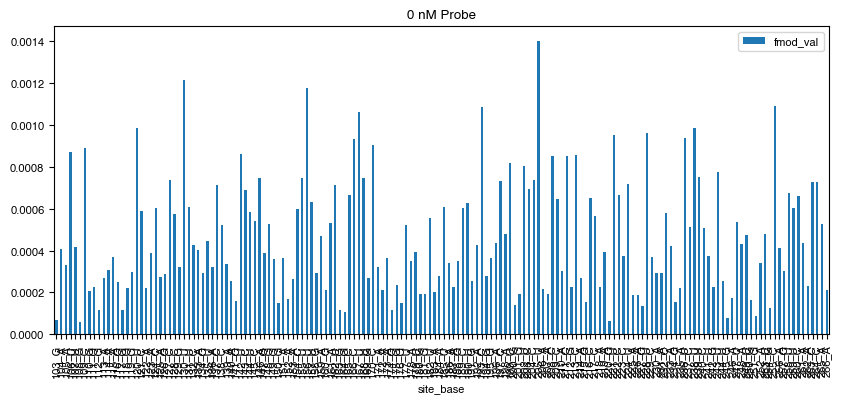

In [23]:
data = read_sql(
    """
    SELECT
        pr.probe_concentration,
        fv.fmod_val,
        s.sample_name,
        mn.site,
        mn.base,
        mn.site || '_' || UPPER(mn.base) AS site_base
    FROM probe_fmod_values fv
    JOIN probe_reactions pr ON pr.id = fv.rxn_id
    JOIN sequencing_samples s ON s.id = pr.s_id
    JOIN meta_nucleotides mn ON mn.id = fv.nt_id
    WHERE pr.rg_id = :rg_id
    AND fv.valtype = 'modrate'
    AND fmod_val > 0.0
    ORDER BY s.sample_name, mn.site
    """,
    {"rg_id": 127},
)

data_0 = data[data["probe_concentration"] == 0.0]
data_0.plot(x="site_base", y="fmod_val", kind="bar", figsize=(10, 4), title="0 nM Probe")

In [29]:
data_merged

,probe_concentration_0,fmod_val_0,sample_name_0,site_0,base_0,site_base,probe_concentration_1,fmod_val_1,sample_name_1,site_1,...,probe_concentration,fmod_val,sample_name,site,base,probe_concentration_3,fmod_val_3,sample_name_3,site_3,base_3
0,0.0,0.000070,029_P4P6_WT_nobc_0mMMgMRTpH83_conc0_rep1,103,G,103_G,0.007926,0.000550,030_P4P6_WT_nobc_0mMMgMRTpH83_conc0p75_rep1,103,...,0.015853,0.001567,031_P4P6_WT_nobc_0mMMgMRTpH83_conc1p5_rep1,103,G,0.031705,0.001575,032_P4P6_WT_nobc_0mMMgMRTpH83_conc3_rep1,103,G
1,0.0,0.000408,029_P4P6_WT_nobc_0mMMgMRTpH83_conc0_rep1,104,A,104_A,0.007926,0.012074,030_P4P6_WT_nobc_0mMMgMRTpH83_conc0p75_rep1,104,...,0.015853,0.023761,031_P4P6_WT_nobc_0mMMgMRTpH83_conc1p5_rep1,104,A,0.031705,0.041255,032_P4P6_WT_nobc_0mMMgMRTpH83_conc3_rep1,104,A
2,0.0,0.000329,029_P4P6_WT_nobc_0mMMgMRTpH83_conc0_rep1,105,A,105_A,0.007926,0.008570,030_P4P6_WT_nobc_0mMMgMRTpH83_conc0p75_rep1,105,...,0.015853,0.018006,031_P4P6_WT_nobc_0mMMgMRTpH83_conc1p5_rep1,105,A,0.031705,0.029640,032_P4P6_WT_nobc_0mMMgMRTpH83_conc3_rep1,105,A
3,0.0,0.000869,029_P4P6_WT_nobc_0mMMgMRTpH83_conc0_rep1,106,U,106_U,0.007926,0.001059,030_P4P6_WT_nobc_0mMMgMRTpH83_conc0p75_rep1,106,...,0.015853,0.002484,031_P4P6_WT_nobc_0mMMgMRTpH83_conc1p5_rep1,106,U,0.031705,0.002485,032_P4P6_WT_nobc_0mMMgMRTpH83_conc3_rep1,106,U
4,0.0,0.000418,029_P4P6_WT_nobc_0mMMgMRTpH83_conc0_rep1,107,U,107_U,0.007926,0.001028,030_P4P6_WT_nobc_0mMMgMRTpH83_conc0p75_rep1,107,...,0.015853,0.002032,031_P4P6_WT_nobc_0mMMgMRTpH83_conc1p5_rep1,107,U,0.031705,0.002361,032_P4P6_WT_nobc_0mMMgMRTpH83_conc3_rep1,107,U
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
159,0.0,0.000230,029_P4P6_WT_nobc_0mMMgMRTpH83_conc0_rep1,262,A,262_A,0.007926,0.004937,030_P4P6_WT_nobc_0mMMgMRTpH83_conc0p75_rep1,262,...,0.015853,0.008889,031_P4P6_WT_nobc_0mMMgMRTpH83_conc1p5_rep1,262,A,0.031705,0.014902,032_P4P6_WT_nobc_0mMMgMRTpH83_conc3_rep1,262,A
160,0.0,0.000728,029_P4P6_WT_nobc_0mMMgMRTpH83_conc0_rep1,263,C,263_C,0.007926,0.000836,030_P4P6_WT_nobc_0mMMgMRTpH83_conc0p75_rep1,263,...,0.015853,0.002379,031_P4P6_WT_nobc_0mMMgMRTpH83_conc1p5_rep1,263,C,0.031705,0.003671,032_P4P6_WT_nobc_0mMMgMRTpH83_conc3_rep1,263,C
161,0.0,0.000729,029_P4P6_WT_nobc_0mMMgMRTpH83_conc0_rep1,264,C,264_C,0.007926,0.000283,030_P4P6_WT_nobc_0mMMgMRTpH83_conc0p75_rep1,264,...,0.015853,0.001278,031_P4P6_WT_nobc_0mMMgMRTpH83_conc1p5_rep1,264,C,0.031705,0.001350,032_P4P6_WT_nobc_0mMMgMRTpH83_conc3_rep1,264,C
162,0.0,0.000529,029_P4P6_WT_nobc_0mMMgMRTpH83_conc0_rep1,265,A,265_A,0.007926,0.000958,030_P4P6_WT_nobc_0mMMgMRTpH83_conc0p75_rep1,265,...,0.015853,0.001925,031_P4P6_WT_nobc_0mMMgMRTpH83_conc1p5_rep1,265,A,0.031705,0.003605,032_P4P6_WT_nobc_0mMMgMRTpH83_conc3_rep1,265,A


In [28]:
data_1 = data[data["probe_concentration"] == data["probe_concentration"].unique()[1]]
data_2 = data[data["probe_concentration"] == data["probe_concentration"].unique()[2]]
data_3 = data[data["probe_concentration"] == data["probe_concentration"].unique()[3]]
# merge data_0, data_1, data_2 and data_3 on site_base
data_merged = data_0.merge(data_1, on="site_base", suffixes=('_0', '_1'))
data_merged = data_merged.merge(data_2, on="site_base", suffixes=('', '_2'))
data_merged = data_merged.merge(data_3, on="site_base", suffixes=('', '_3'))
data_merged

data_merged['fmod_val_1'] -= data_merged['fmod_val_0']
data_merged['fmod_val_2'] -= data_merged['fmod_val_0']
data_merged['fmod_val_3'] -= data_merged['fmod_val_0']
data_merged

KeyError: 'fmod_val_2'

array([0.        , 0.00792635, 0.01585269, 0.03170538])